In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio
import scipy.fftpack
import scipy.signal
import copy
import plotly.express as px
import pandas as pd
%matplotlib inline

## Functions

In [48]:
def findRegionData(regions, regionsMatrix, channelRegion, EEGData):
    """ Extract data from channels located in region(s), based on an atlas given by regionsMatrix.

    Args:
        regions (list): region(s) of interest
        regionsMatrix (ndarray): array with labels of available regions in the atlas

    Returns:
        region_data (ndarray): data from all the channels in region(s) of interest
    """
    if (type(regions)==list):
        id_channel = []
        for region in regions:
            num_channel = np.where(regionsMatrix == region)[0]+1
            id_channel = np.append(id_channel, np.where(channelRegion == num_channel)[0]).astype(int)
    else:
        raise ValueError("Function only accepts strings or lists as 'regions'")
    region_data = EEGData[:,id_channel]
    region_data = region_data.transpose()
    return region_data

In [45]:
def welchMethod(data, srate):
    # create Hann window
    winsize = int( 2.0*srate ) # 2-second window
    hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,winsize))/2

    # number of FFT points (frequency resolution)
    spectres = 0.01; # Hz
    nfft = int(srate/spectres)
    
    # Apply Welch method
    f, welchpow = scipy.signal.welch(data,fs=srate,window=hannw,
                                    nperseg=winsize,noverlap=winsize/2,nfft=nfft, scaling='density')
    
    # Normalizing
    welchpow = np.divide(welchpow, np.sqrt(np.sum(welchpow**2, axis=1)).reshape(welchpow.shape[0],1))

    return f, welchpow

In [51]:
def plotAllChannels(freq, welchpow):
    x_val = [0.5, 4, 8, 13, 30, 80]
    default_x_ticks = range(len(x_val))

    fig, ax = plt.subplots()
    ax.semilogx(freq,welchpow.transpose())
    ax.semilogx([4, 4], [0, 0.12], '--k')
    ax.semilogx([8, 8], [0, 0.12], '--k')
    ax.semilogx([13, 13], [0, 0.12], '--k')
    ax.semilogx([30, 30], [0, 0.12], '--k')
    ax.set_xticks(x_val)
    ax.set_xticklabels(x_val)
    ax.set_xlim([0.5,80])
    ax.set_ylim([0, 0.12])
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('Power')
    plt.show()

In [53]:
def plotPaperFigures(freq, welchpow):
    # Get median:
    median_welchpow = np.median(welchpow, axis=0)
    # Get quartiles
    quant = np.quantile(welchpow, [0.25, 0.75], axis=0)
    # Get max and min
    max_pow = np.max(welchpow, axis=0)
    min_pow = np.min(welchpow, axis=0)

    # Plot
    x_val = [0.5, 4, 8, 13, 30, 80]
    default_x_ticks = range(len(x_val))

    fig, ax = plt.subplots()
    ax.semilogx(freq, median_welchpow, 'r')
    ax.fill_between(freq,
                    quant[0,:],
                    quant[1, :],
                    alpha=0.2, color='tab:pink')
    ax.semilogx(freq, max_pow, '--', color='tab:orange')
    ax.semilogx(freq, min_pow, '--', color='tab:orange')
    ax.semilogx([4, 4], [0, 0.12], '--k')
    ax.semilogx([8, 8], [0, 0.12], '--k')
    ax.semilogx([13, 13], [0, 0.12], '--k')
    ax.semilogx([30, 30], [0, 0.12], '--k')
    ax.set_xticks(x_val)
    ax.set_xticklabels(x_val)
    ax.set_xlim([0.5,80])
    ax.set_ylim([0, 0.12])
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('Power')
    # ax.set_xscale('log')
    plt.show()
        

In [77]:
def plotInteractiveFFT(freq, welchpow):
    # Get median:
    median_welchpow = np.median(welchpow, axis=0)
    # Plot
    df = pd.DataFrame({
        'Amplitude' : median_welchpow,
        'Frequency (hz)' : freq
    })
    fig = px.line(df, x="Frequency (hz)", y="Amplitude", log_x=True)
    fig.update_layout(xaxis_range=[np.log(0.5),np.log10(80)])
    fig.show()

## Load and prepare data


In [13]:
# load data and extract
matdat  = sio.loadmat(('/media/mcespedes/MauricioCT_Drive/Documents/'
                       'Master/Projects/Atlas_Normal_iEEG/Downloaded_Atlas/MNI Open iEEG Atlas'
                       '/MatlabFile/MatlabFile.mat'))

In [14]:
# Sampling rate
srate = matdat['SamplingFrequency'][0]
# Channel region and reshaping:
channelRegion = matdat['ChannelRegion']
channelRegion = np.array(channelRegion).reshape(1,channelRegion.size)[0]
# Channel region and reshaping:
regionName = matdat['RegionName']
regionName = np.array([region[0] for region in regionName.reshape(1,regionName.size)[0][:]])
# EEG data:
EEGdata = np.array(matdat['Data_W'])
# Reallocate space used by the rest of the original data
del(matdat)

In [15]:
# Time vector for plotting:
N = EEGdata.shape[0] # number of point
t = np.arange(0, N)/srate

## Plot specific regions

### Hippocampus

In [49]:
channel_data = findRegionData(['Hippocampus'],regionName, channelRegion, EEGdata)

In [50]:
channel_data.shape

(36, 13600)

In [39]:
# ERP for the channel:
df = pd.DataFrame({
    'Amplitude (mV)' : np.mean(channel_data, axis = 0),
    'Time (s)' : t
})
fig = px.line(df, x="Time (s)", y="Amplitude (mV)", title='Hippocampus ERP')
fig.show()

In [46]:
f, welchpow = welchMethod(channel_data, srate)

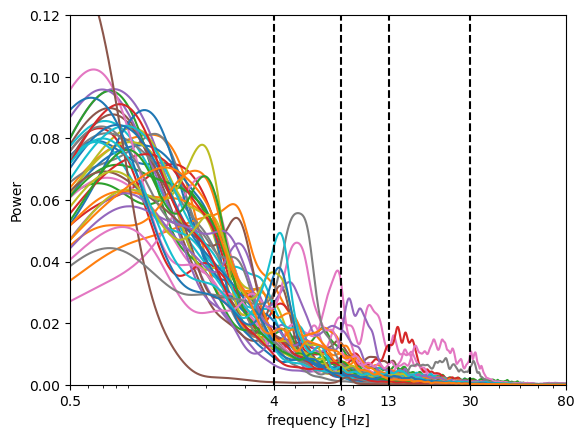

In [52]:
plotAllChannels(f, welchpow)

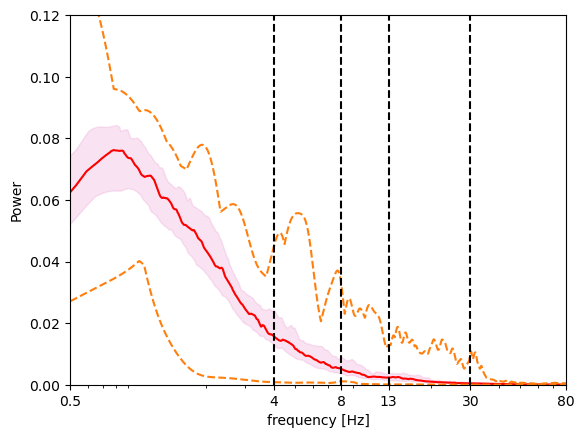

In [54]:
plotPaperFigures(f, welchpow)

In [78]:
plotInteractiveFFT(f, welchpow)

## Plot lobes

In [57]:
regionsInfo = pd.read_csv('/media/mcespedes/MauricioCT_Drive/Documents/Master/Projects/Atlas_Normal_iEEG/Downloaded_Atlas/MNI Open iEEG Atlas/Information/RegionInformation.csv')

In [70]:
regionLabels = [region[1:-1] for region in regionsInfo[regionsInfo.Lobe == 'Frontal']['Region name']]

In [71]:
channel_data = findRegionData(regionLabels,regionName, channelRegion, EEGdata)

In [73]:
channel_data.shape

(797, 13600)

In [74]:
f, welchpow = welchMethod(channel_data, srate)

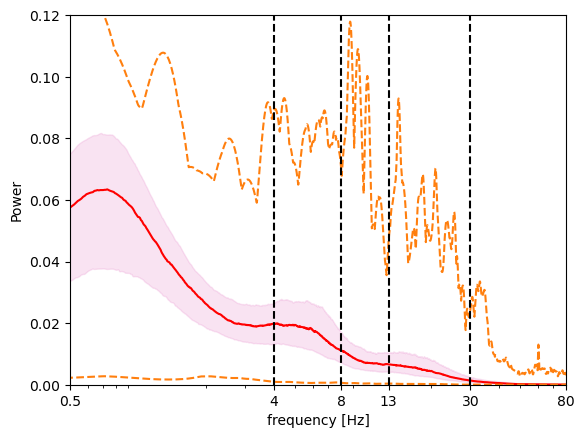

In [75]:
plotPaperFigures(f, welchpow)

In [76]:
plotInteractiveFFT(f, welchpow)

# FFT

In [79]:
eegpow = np.abs( scipy.fftpack.fft(channel_data)/N )**2
hz = np.linspace(0,srate/2,int(np.floor(N/2)+1))

In [80]:
eegpow = np.divide(eegpow, np.sqrt(np.sum(eegpow**2, axis=1)).reshape(eegpow.shape[0],1))

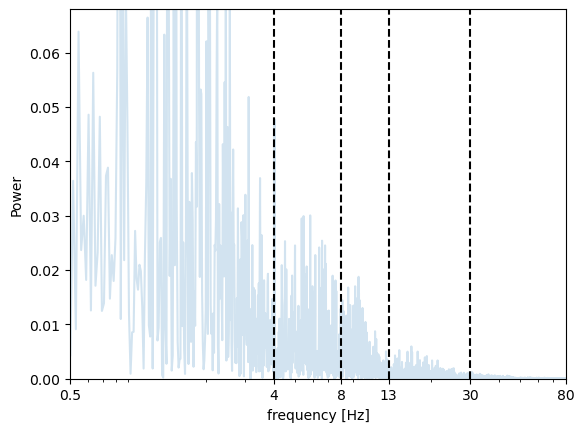

In [84]:
fig, ax = plt.subplots()
ax.semilogx(hz,eegpow[3,0:len(hz)].transpose(),alpha=0.2)
ax.semilogx([4, 4], [0, 0.068], '--k')
ax.semilogx([8, 8], [0, 0.068], '--k')
ax.semilogx([13, 13], [0, 0.068], '--k')
ax.semilogx([30, 30], [0, 0.068], '--k')
ax.set_xticks(x_val)
ax.set_xticklabels(x_val)
ax.set_xlim([0.5,80])
ax.set_ylim([0, 0.068])
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('Power')
# ax.set_xscale('log')
plt.show()

In [81]:
median_eegpow = np.median(eegpow, axis=0)

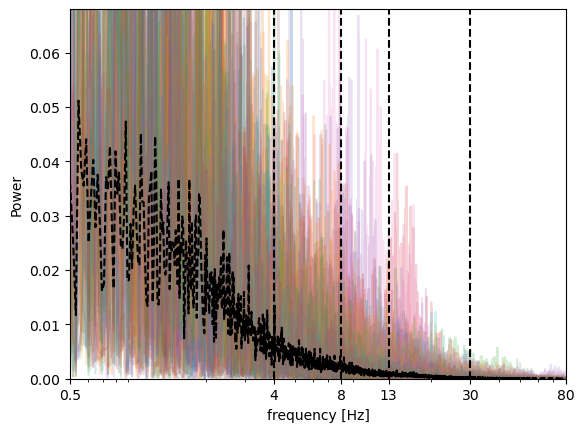

In [82]:
x_val = [0.5, 4, 8, 13, 30, 80]
default_x_ticks = range(len(x_val))

fig, ax = plt.subplots()
ax.semilogx(hz,eegpow[:,0:len(hz)].transpose(),alpha=0.2)
ax.semilogx(hz, median_eegpow[0:len(hz)].transpose(), '--k')
ax.semilogx([4, 4], [0, 0.068], '--k')
ax.semilogx([8, 8], [0, 0.068], '--k')
ax.semilogx([13, 13], [0, 0.068], '--k')
ax.semilogx([30, 30], [0, 0.068], '--k')
ax.set_xticks(x_val)
ax.set_xticklabels(x_val)
ax.set_xlim([0.5,80])
ax.set_ylim([0, 0.068])
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('Power')
# ax.set_xscale('log')
plt.show()

In [21]:
import mne
file = "/media/mcespedes/MauricioCT_Drive/Documents/Master/Projects/Atlas_Normal_iEEG/Downloaded_Atlas/MNI Open iEEG Atlas/Wakefulness_AllRegions/Hippocampus_W.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()

Extracting EDF parameters from /media/mcespedes/MauricioCT_Drive/Documents/Master/Projects/Atlas_Normal_iEEG/Downloaded_Atlas/MNI Open iEEG Atlas/Wakefulness_AllRegions/Hippocampus_W.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [32]:
data.info

<Info | 7 non-empty values
 bads: []
 ch_names: GD002Rb1W, GD002Rb2W, GD008Lb_1W, GD008Lb_2W, GD008Lb_3W, ...
 chs: 36 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: 1970-01-01 00:00:00 UTC
 nchan: 36
 projs: []
 sfreq: 200.0 Hz
>

In [22]:
# Welch method
# create Hann window
winsize = int( 2*srate ) # 2-second window
hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,winsize))/2

# number of FFT points (frequency resolution)
spectres = 0.5 # Hz
nfft = srate*100.0

In [23]:
f, welchpow = scipy.signal.welch(raw_data,fs=srate,window=hannw,nperseg=winsize,noverlap=winsize/2,nfft=nfft)

In [24]:
welchpow = np.divide(welchpow, np.sqrt(np.sum(welchpow**2, axis=1)).reshape(welchpow.shape[0],1))

In [ ]:
welchpow.shape

In [25]:
# Normalization:
welchpow = np.divide(welchpow, welchpow.max(axis=1).reshape(36,1))
# Get median:
median_welchpow = np.median(welchpow, axis=0)
# FFT for the channel:
df = pd.DataFrame({
    'Amplitude' : median_welchpow,
    'Frequency (hz)' : f
})
fig = px.line(df, x="Frequency (hz)", y="Amplitude", title='Hippocampus FFT')
fig.show()